---

***Filename***: supplement.ipynb

---

***Description***: This notebook demonstrates the process of computing the inharmonicity coefficient.

---

***Author***: Alexandros Iliadis

***Project***: GS-Detector

***Date***: February 2024

---

#### Section I:

This section handles preliminary tasks such as assigning the working directory, importing necessary modules, selecting the dataset for demonstration, and configuring variables related to the guitar setup.

In [6]:
# Mount Drive
from google.colab import drive
drive.mount("/content/gdrive")

# Change Directory
import os
cwd = "/content/gdrive/My Drive/Colab/MSc/Audio Signal Processing/Project"
os.chdir(cwd)

In [7]:
# Import Modules
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xml
from scipy.optimize import curve_fit
from scipy.signal import stft,find_peaks

In [8]:
# Select Dataset
dataset_selection = 0
dataset = ["Bridge Pickup","Middle Pickup","Neck Pickup"][dataset_selection % 3]

# Set Paths
dataset_path = os.path.join(cwd,"Datasets",dataset)
audio_path = os.path.join(dataset_path,"audio")
annotation_path = os.path.join(dataset_path,"annotation")

In [9]:
# Configure Guitar Setup
tuning = dict(zip(["E4","B3","G3","D3","A2","E2"],[64,59,55,50,45,40]))
num_of_strings = len(tuning)
num_of_frets = 12 + 1
fretboard = np.array(list(tuning.values()))[:,np.newaxis] + np.arange(num_of_frets)

# Assign Note Pitches to Fundamental Frequencies
pitches = np.arange(list(tuning.values())[-1],list(tuning.values())[0] + num_of_frets)
fundamentals = dict(zip(pitches,440*2**((pitches - 69)/12)))

#### Section II:

This section computes the inharmonicity coefficient for a chosen note of the selected dataset. The approach includes applying the Short-Time Fourier Transform (STFT) on the note signal and performing partial tracking on a selected audio block between the onset and offset timestamps. Once the partial frequencies have been detected, a curve-fitting process is deployed to extract the inharmonicity coefficient.

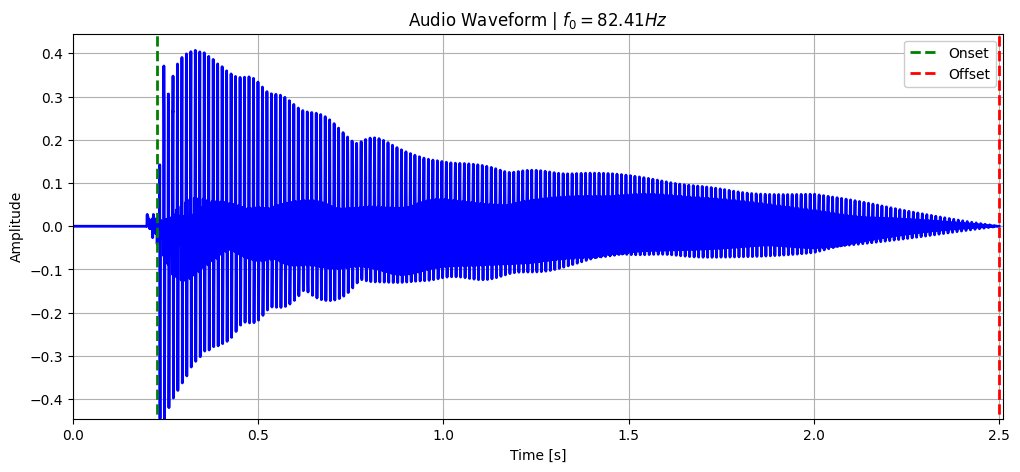

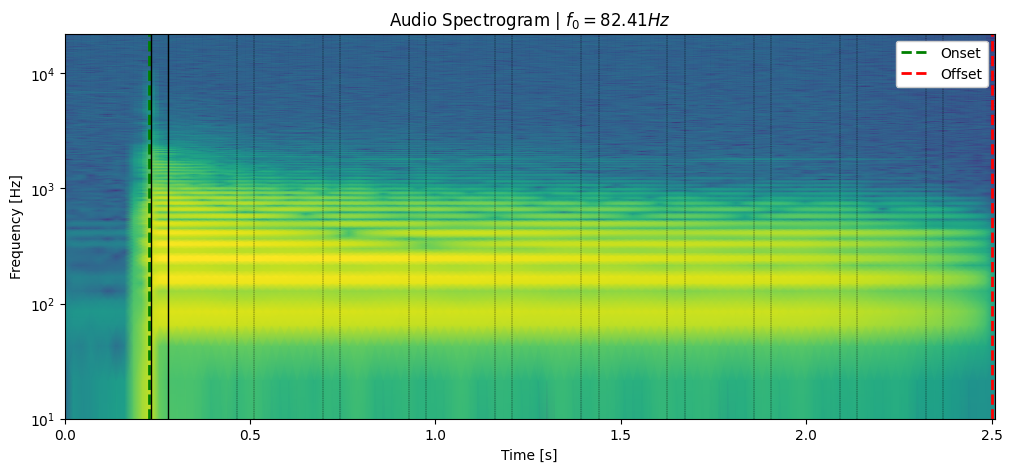

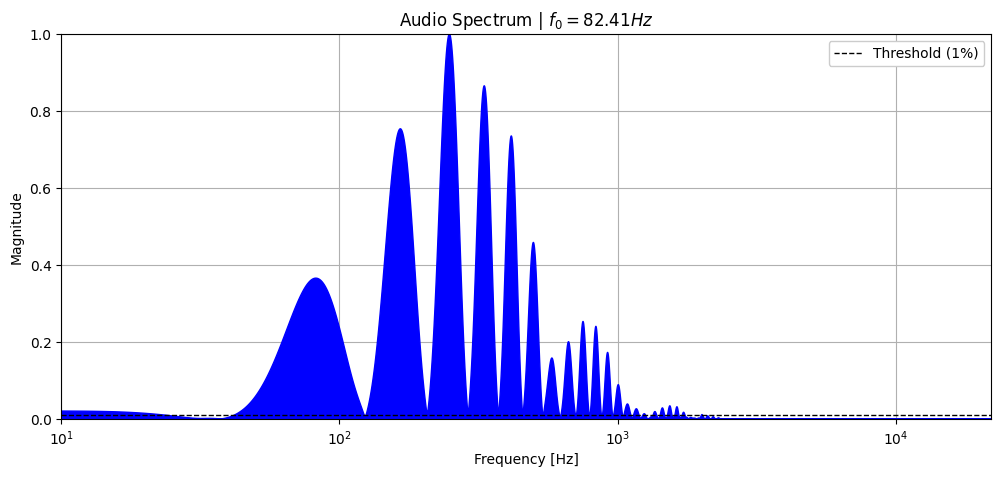

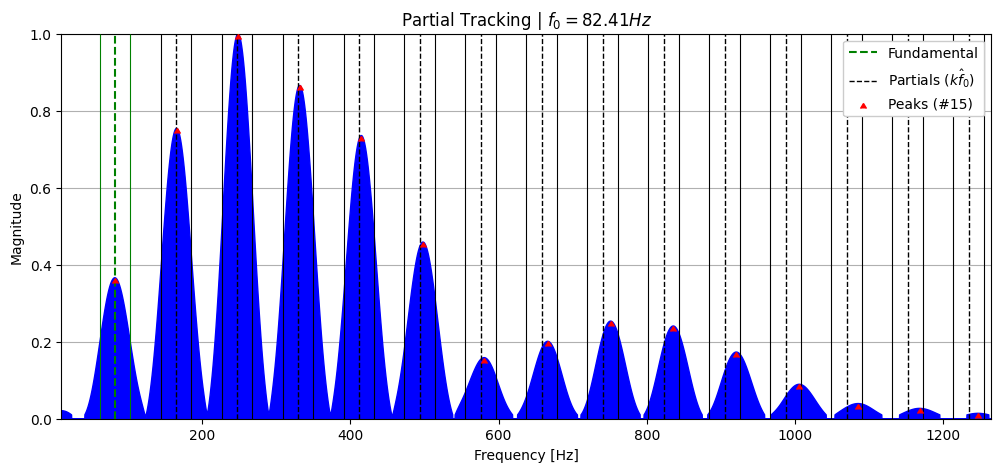

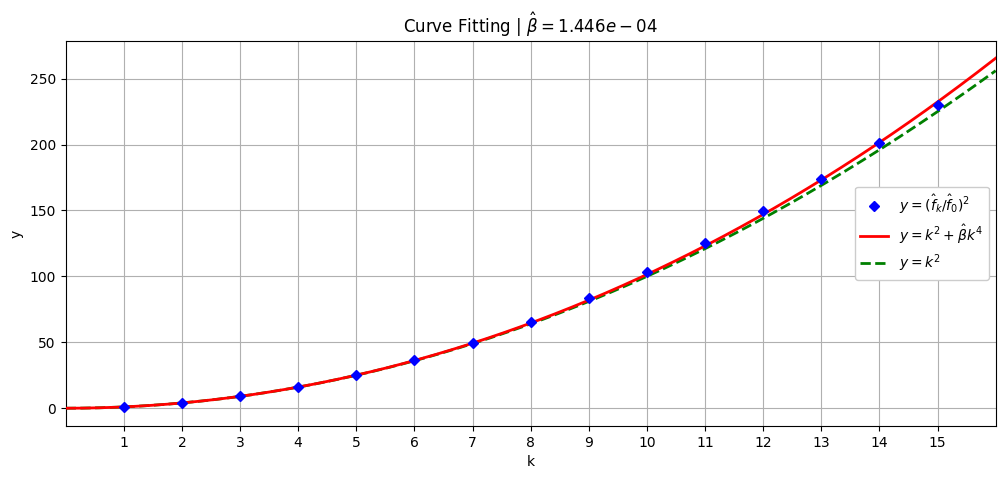

In [10]:
# Loop Through Files
files = sorted(os.listdir(annotation_path))
for file in files:

    # Load Annotation
    annotation_file = os.path.join(annotation_path,file)
    annotation = xml.parse(annotation_file).getroot()[1][0]
    pitch = int(annotation.find('pitch').text)
    string = 7 - int(annotation.find('stringNumber').text)
    fret = int(annotation.find('fretNumber').text)
    onset = float(annotation.find('onsetSec').text)
    offset = float(annotation.find('offsetSec').text)
    f0 = fundamentals[pitch]

    # Choose Note for Demonstration
    if(string == 6 and fret == 0):

        # Load Audio
        audio_file = os.path.join(audio_path,file[:-4] + ".wav")
        audio,fs = sf.read(audio_file)

        # Plat Audio Waveform
        fig = plt.figure(figsize = (12,5))
        t_axis = np.arange(len(audio))/fs
        plt.plot(t_axis,audio,color = 'b',linestyle = '-',linewidth = 2)
        plt.vlines(onset,-1,1,colors = 'g',linestyles = '--',linewidths = 2,label = "Onset")
        plt.vlines(offset,-1,1,colors = 'r',linestyles = '--',linewidths = 2,label = "Offset")
        plt.xlim(t_axis[0],t_axis[-1] + 0.01)
        plt.ylim(-np.max(np.abs(audio)),np.max(np.abs(audio)))
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        plt.title(f"Audio Waveform | $f_{0}={f0:.2f} Hz$")
        plt.legend(loc = 'upper right',framealpha = 1)
        plt.grid(True,zorder = 1)

        # Get Spectrogram
        window_type = 'hann'
        window_length = 2048
        overlap_length = window_length/2
        fft_length = 2**18
        f_axis,t_axis,spectrogram = stft(audio,fs,window_type,window_length,overlap_length,fft_length)

        # Select Block for Demonstration
        block_selection = 0
        blocks = np.where((t_axis >= onset + (window_length/2)/fs) & (t_axis <= offset - (window_length/2)/fs))[0]
        block = blocks[block_selection % len(blocks)]

        # Plot Audio Spectrogram
        fig = plt.figure(figsize = (12,5))
        plot = plt.pcolormesh(t_axis,f_axis[::int((fft_length/window_length))],10*np.log10(np.abs(spectrogram[::int((fft_length/window_length)),:])**2),shading = 'gouraud')
        plt.vlines(onset,10,fs/2,colors = 'g',linestyles = '--',linewidths = 2,label = "Onset")
        plt.vlines(offset,10,fs/2,colors = 'r',linestyles = '--',linewidths = 2,label = "Offset")
        plt.vlines([t_axis[block] - (window_length/2)/fs,t_axis[block] + (window_length/2)/fs],10,fs/2,colors = 'k',linestyles = '-',linewidths = 1)
        plt.vlines(np.sort(np.append(t_axis[block + 10::10] - (window_length/2)/fs,t_axis[block + 10::10] + (window_length/2)/fs)),10,fs/2,colors = 'k',linestyles = '--',linewidths = 0.3)
        plt.ylim(10,fs/2)
        plt.yscale('symlog')
        plt.xlabel("Time [s]")
        plt.ylabel("Frequency [Hz]")
        plt.title(f"Audio Spectrogram | $f_{0}={f0:.2f} Hz$")
        plt.legend(loc = 'upper right',framealpha = 1)

        # Get Spectrum
        spectrum = np.abs(spectrogram[:,block])
        spectrum = (spectrum-np.min(spectrum))/(np.max(spectrum) - np.min(spectrum))
        threshold = 0.01

        # Plot Audio Spectrum
        fig = plt.figure(figsize = (12,5))
        plt.fill_between(f_axis,np.min(spectrum),spectrum,color = 'b',zorder = 2)
        plt.hlines(threshold,10,fs/2,colors = 'k',linestyles = '--',linewidths = 1,zorder = 3,label = f"Threshold ({int(threshold*100)}%)")
        plt.xlim(10,fs/2)
        plt.ylim(0,1)
        plt.xscale('symlog')
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Magnitude")
        plt.title(f"Audio Spectrum | $f_{0}={f0:.2f} Hz$")
        plt.legend(loc = 'upper right',framealpha = 1)
        plt.grid(True,zorder = 1)
        
        # Track Partials
        spectrum[spectrum <= threshold] = 0
        search_window = f0/2
        max_partials = np.minimum(15,int((fs/2)/f0))
        fk_estimated = np.zeros(max_partials)
        fk_index = np.zeros(max_partials,dtype = int)
        fk_computed = np.zeros(max_partials)
        for k in range(max_partials):
            if k == 0:
                fk_estimated[k] = (k + 1)*f0
                search_window = fk_estimated[k]/2
            else:
                fk_estimated[k] = (k + 1)*fk_computed[0]
            search_range = np.where((f_axis > fk_estimated[k] - search_window/2) & (f_axis < fk_estimated[k] + search_window/2))[0]
            peaks = find_peaks(spectrum[search_range])[0]
            if peaks.size == 0:
                k = k - 1
                break
            fk_index[k] = search_range[peaks[np.argmax(spectrum[search_range][peaks])]]
            fk_computed[k] = f_axis[fk_index[k]]
        k = k + 1
        fk_estimated = fk_estimated[:k]
        fk_index = fk_index[:k]
        fk_computed = fk_computed[:k]

        # Compute Inharmonicity Coefficient
        if(k >= 2):
            k_axis = np.arange(k) + 1
            ratio = (fk_computed/fk_computed[0])**2
            B = curve_fit(lambda k,B : k**2 + B*k**4,k_axis,ratio,bounds = (0,np.inf))[0][0]
        else:
            B = np.nan

        # Plot Partial Tracking
        fig = plt.figure(figsize = (12,5))
        plt.fill_between(f_axis,np.min(spectrum),spectrum,color = 'b',zorder = 2)
        plt.vlines(fk_estimated[0],0,1,colors = 'g',linestyles = '--',linewidths = 1.5,zorder = 4,label = "Fundamental")
        plt.vlines(np.sort(np.append(f0 - f0/4,f0 + f0/4)),0,1,colors = 'g',linestyles = '-',linewidths = 0.8,zorder = 3)
        plt.vlines(fk_estimated[1:],0,1,colors = 'k',linestyles = '--',linewidths = 1,zorder = 3,label = "Partials ($k\\hat{f}_{0}$)")
        plt.vlines(np.sort(np.append(fk_estimated[1:] - search_window/2,fk_estimated[1:] + search_window/2)),0,1,colors = 'k',linestyles = '-',linewidths = 0.8,zorder = 3)
        plt.plot(f_axis[fk_index],spectrum[fk_index],color = 'r',linestyle = '',marker = 6,markersize = 5,zorder = 5,label = f"Peaks (#{k})")
        plt.xlim(10,fk_estimated[-1] + search_window/2 + 10)
        plt.ylim(0,1)
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Magnitude")
        plt.title(f"Partial Tracking | $f_{0}={f0:.2f} Hz$")
        plt.legend(loc = 'upper right',framealpha = 1)
        plt.grid(True,zorder = 1,axis = 'y')

        # Plot Curve Fitting
        fig = plt.figure(figsize = (12,5))
        curve_axis = np.linspace(0,k + 1,(k + 1)*100)
        plt.plot(k_axis,ratio,color = 'b',linestyle = '',marker = 'D',markersize = 5,zorder = 4,label = "$y = (\\hat{f}_{k}/\\hat{f}_{0})^{2}$")
        plt.plot(curve_axis,B*curve_axis**4 + curve_axis**2,color = 'r',linestyle = '-',linewidth = 2,zorder = 3,label = "$y = k^{2} + \\hat{\\beta} k^{4}$")
        plt.plot(curve_axis,curve_axis**2,color = 'g',linestyle = '--',linewidth = 2,zorder = 2,label = "$y = k^{2}$")
        plt.xlim(0,k + 1)
        plt.xticks(k_axis)
        plt.xlabel("k")
        plt.ylabel("y")
        plt.title(f"Curve Fitting | $\\hat\\beta={'{:.3e}'.format(B)}$")
        plt.legend(loc = 'center right',framealpha = 1)
        plt.grid(True,zorder = 1)